## 示例一：Function Fitting（功能拟合）
    在这个模块中，我们将演示如何充分利用网格细化技术来最大程度地利用KANs的拟合能力。

## 先引入之后将使用的包。

In [24]:
from kan import *

## 初始化模型后创建数据集。

In [25]:
model = KAN(width=[2,1,1], grid=3, k=3)

f = lambda x: torch.exp(torch.sin(torch.pi*x[:,[0]]) + x[:,[1]]**2)
dataset = create_dataset(f, n_var=2)

## 训练KAN（将网格数设置为3）

In [26]:
model.train(dataset, opt="LBFGS", steps=20);

train loss: 1.45e-02 | test loss: 1.51e-02 | reg: 2.97e+00 : 100%|██| 20/20 [00:03<00:00,  6.39it/s]


可以发现损失与MLP相比相差不大。也就是说，我们需要一个更加精细的KAN。

## 重新训练KAN，这次将网格数设置为10.

In [27]:
model2 = KAN(width=[2,1,1], grid=10, k=3)

model2.initialize_from_another_model(model, dataset['train_input']);
model2.train(dataset, opt="LBFGS", steps=20);

train loss: 3.95e-04 | test loss: 3.90e-04 | reg: 2.97e+00 : 100%|██| 20/20 [00:03<00:00,  5.99it/s]


我们惊喜地发现，损失变小了。我们可以尝试进一步细化网格。

In [28]:
grids = np.array([5,10,20,50,100])

train_losses = []
test_losses = []
steps = 50
k = 3

for i in range(grids.shape[0]):
    if i == 0:
        model = KAN(width=[2,1,1], grid=grids[i], k=k)
    if i != 0:
        model = KAN(width=[2,1,1], grid=grids[i], k=k).initialize_from_another_model(model, dataset['train_input'])
    results = model.train(dataset, opt="LBFGS", steps=steps, stop_grid_update_step=30)
    train_losses += results['train_loss']
    test_losses += results['test_loss']

train loss: 6.41e-03 | test loss: 6.55e-03 | reg: 2.78e+00 : 100%|██| 50/50 [00:07<00:00,  6.43it/s]
train loss: 2.88e-04 | test loss: 3.23e-04 | reg: 2.80e+00 : 100%|██| 50/50 [00:06<00:00,  8.02it/s]
train loss: 1.87e-05 | test loss: 2.04e-05 | reg: 2.80e+00 : 100%|██| 50/50 [00:05<00:00,  8.88it/s]
train loss: 3.06e-06 | test loss: 6.40e-06 | reg: 2.80e+00 : 100%|██| 50/50 [00:04<00:00, 11.26it/s]
train loss: 2.44e-06 | test loss: 5.33e-06 | reg: 2.80e+00 : 100%|██| 50/50 [00:03<00:00, 13.70it/s]


## 将训练损失与测试损失的动态可视化。
    发现它们呈现阶梯结构。（损失在每次细化网格后骤降）

Text(0.5, 1.0, '训练损失与动态损失变化对比图-王一诺')

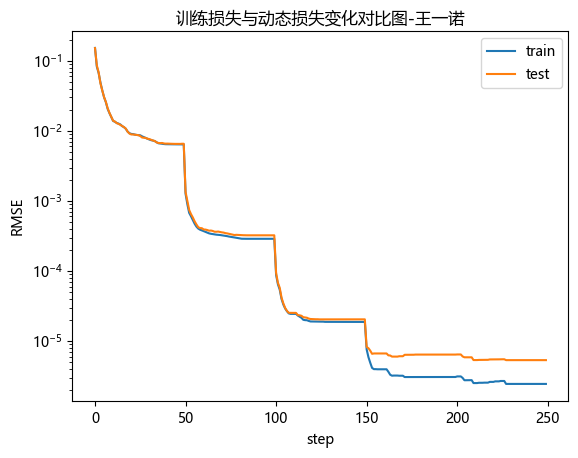

In [29]:
plt.rcParams['font.sans-serif']=['Microsoft YaHei']
plt.plot(train_losses)
plt.plot(test_losses)
plt.legend(['train', 'test'])
plt.ylabel('RMSE')
plt.xlabel('step')
plt.yscale('log')
plt.title("训练损失与动态损失变化对比图-王一诺")

Neural scaling laws（神经网络规模定律）描述了神经网络在不同规模（如网络的大小、宽度、深度等）下的性能变化趋势。接下来我们将可视化神经网络规模（参数数量）与性能（均方根误差，RMSE）之间的关系。具体来说，生成的这个图表将展示训练误差和测试误差随着模型参数数量变化的情况，并与一个下降的四次方关系进行了对比。

Text(0.5, 1.0, '训练误差和测试误差随着模型参数数量的变化图-王一诺')

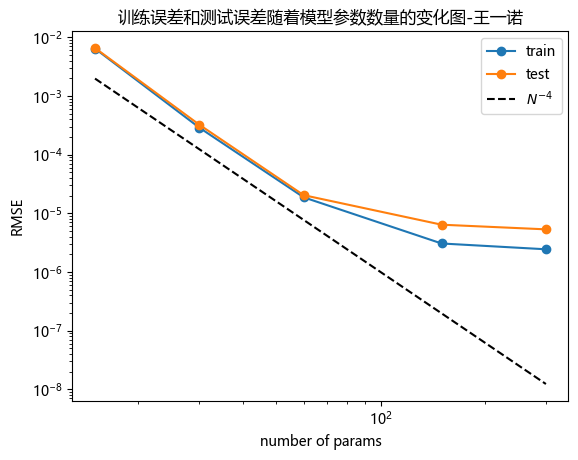

In [30]:
n_params = 3 * grids
train_vs_G = train_losses[(steps-1)::steps]
test_vs_G = test_losses[(steps-1)::steps]
plt.plot(n_params, train_vs_G, marker="o")
plt.plot(n_params, test_vs_G, marker="o")
plt.plot(n_params, 100*n_params**(-4.), ls="--", color="black")
plt.xscale('log')
plt.yscale('log')
plt.legend(['train', 'test', r'$N^{-4}$'])
plt.xlabel('number of params')
plt.ylabel('RMSE')
plt.title("训练误差和测试误差随着模型参数数量的变化图-王一诺")

综合来看，这张图表用于展示神经网络规模定律中的一个关键观察：随着模型参数数量的增加，训练和测试误差通常会下降，但可能会随着参数数量的增加而逐渐趋于平缓。同时，通过与四次方下降趋势线的对比，可以评估模型性能的改善是否符合理论上的预期。

# 示例二：Deep Formulas（深度公式）
原始的科尔莫戈洛夫-阿诺德定理表明，只需要有两层函数组合（内层和外层函数），但函数可能是非平滑甚至是分形的。我们将KAN表示推广到任意深度。一个二层KAN（具有平滑激活函数）无法完成的一个示例是：$f(x1,x2,x3,x4)={\rm exp}({\rm sin}(x1^2+x2^2)+{\rm sin}(x3^2+x4^2))$，这至少需要三层KAN。

## 三层 KAN

### 创建KAN模型

创建一个KAN模型，它有三个隐藏层。width参数指定了每一层的神经元数量，grid指定了网络的网格大小，k指定了样条插值的阶数，seed是随机种子用于初始化模型参数。

In [ ]:
from kan import KAN, create_dataset
import torch
import matplotlib.pyplot as plt

# create a KAN: 2D inputs, 1D output, and 5 hidden neurons. cubic spline (k=3), 5 grid intervals (grid=5).
model = KAN(width=[4,2,1,1], grid=3, k=3, seed=0)

### 定义目标函数并创建数据集
目标函数为：$f(x1,x2,x3,x4)={\rm exp}({\rm sin}(x1^2+x2^2)+{\rm sin}(x3^2+x4^2))$

生成数据集，其中包含3000个训练样本，特征数量为4。

In [ ]:
f = lambda x: torch.exp((torch.sin(torch.pi*(x[:,[0]]**2+x[:,[1]]**2))+torch.sin(torch.pi*(x[:,[2]]**2+x[:,[3]]**2)))/2)
dataset = create_dataset(f, n_var=4, train_num=3000)

### 训练模型
使用LBFGS优化器对模型进行训练。

In [ ]:
model.train(dataset, opt="LBFGS", steps=20, lamb=0.001, lamb_entropy=2.);

### 可视化模型
可视化训练后的模型，展示了模型的结构。

In [ ]:
# 在绘图之前设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']  
plt.rcParams['axes.unicode_minus'] = False

model.plot(beta=10, title='三层KAN模型性能可视化-毛奕婷')

### 移除边缘

In [ ]:
# 手动删除边缘似乎对结果没有太大影响，但为了完整起见，我们还是将它们包含在内。
remove_edge = True

if remove_edge == True:
    model.remove_edge(0,0,1)
    model.remove_edge(0,1,1)
    model.remove_edge(0,2,0)
    model.remove_edge(0,3,0)
else:
    pass

### 调整网格大小并重新训练

在每次迭代中，创建一个新的KAN模型。然后使用initialize_from_another_model方法，以保持模型参数的连续性，并将其应用于新的训练集。

其次对新创建的模型进行训练。使用了LBFGS优化器，进行了50个步骤的训练，并在达到30个步骤后停止更新网格。

然后将训练和测试误差记录到train_rmse和test_rmse列表中。

In [ ]:
grids = [3,5,10,20,50]
#grids = [5]

train_rmse = []
test_rmse = []

for i in range(len(grids)):
    model = KAN(width=[4,2,1,1], grid=grids[i], k=3, seed=0).initialize_from_another_model(model, dataset['train_input'])
    results = model.train(dataset, opt="LBFGS", steps=50, stop_grid_update_step=30);
    train_rmse.append(results['train_loss'][-1].item())
    test_rmse.append(results['test_loss'][-1].item())

### 绘制结果
绘制训练和测试误差的理论曲线

In [ ]:
import numpy as np

n_params = np.array(grids) * (4*2+2*1+1*1)
plt.rcParams['font.sans-serif']=['Microsoft YaHei']
plt.plot(n_params, train_rmse, marker="o")
plt.plot(n_params, test_rmse, marker="o")
plt.plot(n_params, 10000*n_params**(-4.), color="black", ls="--")
plt.legend(['train', 'test', r'$N^{-4}$'], loc="lower left")
plt.xscale('log')
plt.yscale('log')
plt.title('三层KAN模型性能与复杂性的关系-毛奕婷', fontsize=15)
print(train_rmse)
print(test_rmse)

## 两层KAN

两层的KAN在这个任务中性能得要差得多

### 创建KAN模型:

创建一个KAN模型。模型有三层，分别为输入层（4个神经元，即4D输入），隐藏层（9个神经元），和输出层（1个神经元，即1D输出），每个维度使用3个网格间隔，并设置随机种子以保证结果的可复现性。

In [ ]:
from kan import KAN, create_dataset
import torch

model = KAN(width=[4,9,1], grid=3, k=3, seed=0)

### 定义目标函数并创建数据集
目标函数为：$f(x1,x2,x3,x4)={\rm exp}({\rm sin}(x1^2+x2^2)+{\rm sin}(x3^2+x4^2))$

生成数据集，其中包含3000个训练样本，特征数量为4。

In [ ]:
f = lambda x: torch.exp((torch.sin(torch.pi*(x[:,[0]]**2+x[:,[1]]**2))+torch.sin(torch.pi*(x[:,[2]]**2+x[:,[3]]**2)))/2)
dataset = create_dataset(f, n_var=4, train_num=3000)

### 训练模型
使用LBFGS优化器对模型进行训练。

In [ ]:
# train the model
model.train(dataset, opt="LBFGS", steps=20, lamb=0.001, lamb_entropy=2.);

### 使用不同的网格数量重新训练并分析性能:

循环通过不同数量的网格间隔，为每个配置创建新的KAN模型并从之前训练的模型复制初始化参数。

每个模型通过50步的LBFGS优化训练，其中在30步后停止更新网格。

记录每个配置下的训练和测试集上的均方根误差（RMSE），分别存储在train_rmse和test_rmse列表中。


In [ ]:
grids = [3,5,10,20,50]
#grids = [5]

train_rmse = []
test_rmse = []

for i in range(len(grids)):
    model = KAN(width=[4,9,1], grid=grids[i], k=3, seed=0).initialize_from_another_model(model, dataset['train_input'])
    results = model.train(dataset, opt="LBFGS", steps=50, stop_grid_update_step=30);
    train_rmse.append(results['train_loss'][-1].item())
    test_rmse.append(results['test_loss'][-1].item())

### 绘制结果
绘制训练和测试误差的理论曲线

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif']=['Microsoft YaHei']
plt.rcParams['axes.unicode_minus']=False
n_params = np.array(grids) * (4*9+9*1)
plt.plot(n_params, train_rmse, marker="o")
plt.plot(n_params, test_rmse, marker="o")
plt.plot(n_params, 300*n_params**(-2.), color="black", ls="--")
plt.legend(['train', 'test', r'$N^{-4}$'], loc="lower left")
plt.xscale('log')
plt.yscale('log')
plt.title('两层KAN模型性能与复杂性的关系-毛奕婷', fontsize=15)
print(train_rmse)
print(test_rmse)

## 示例三：Classification（分类）
## 一、回归公式
    让我们先将这个问题看作一个回归问题。

## 设置输出维度为1，损失类型为MSE。
    首先创建两个弯月形数据集。

Text(0.5, 1.0, '两个弯月形数据集可视化图-王一诺')

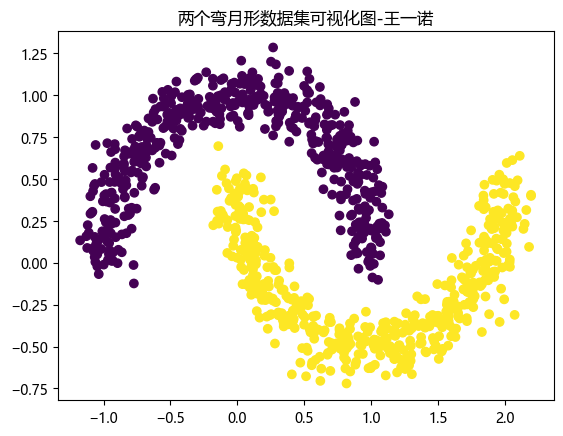

In [31]:
from kan import KAN
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
import torch
import numpy as np
plt.rcParams['font.sans-serif']=['Microsoft YaHei']

dataset = {}
train_input, train_label = make_moons(n_samples=1000, shuffle=True, noise=0.1, random_state=None)
test_input, test_label = make_moons(n_samples=1000, shuffle=True, noise=0.1, random_state=None)

dataset['train_input'] = torch.from_numpy(train_input)
dataset['test_input'] = torch.from_numpy(test_input)
dataset['train_label'] = torch.from_numpy(train_label[:,None])
dataset['test_label'] = torch.from_numpy(test_label[:,None])

X = dataset['train_input']
y = dataset['train_label']
plt.scatter(X[:,0], X[:,1], c=y[:,0])
plt.title("两个弯月形数据集可视化图-王一诺")

## 训练KAN。

In [32]:
model = KAN(width=[2,1], grid=3, k=3)

def train_acc():
    return torch.mean((torch.round(model(dataset['train_input'])[:,0]) == dataset['train_label'][:,0]).float())

def test_acc():
    return torch.mean((torch.round(model(dataset['test_input'])[:,0]) == dataset['test_label'][:,0]).float())

results = model.train(dataset, opt="LBFGS", steps=20, metrics=(train_acc, test_acc));
results['train_acc'][-1], results['test_acc'][-1]

train loss: 1.52e-01 | test loss: 1.56e-01 | reg: 4.21e+00 : 100%|██| 20/20 [00:02<00:00,  9.54it/s]


(0.9990000128746033, 0.9980000257492065)

## 利用KAN进行自动符号回归。

In [33]:
lib = ['x','x^2','x^3','x^4','exp','log','sqrt','tanh','sin','tan','abs']
model.auto_symbolic(lib=lib)
formula = model.symbolic_formula()[0][0]
formula

fixing (0,0,0) with sin, r2=0.9730595155886805
fixing (0,1,0) with tan, r2=0.967862043693618


-0.39*sin(3.15*x_1 - 1.58) - 0.92*tan(0.81*x_2 - 9.6) + 0.54

这个公式到底有多准确？下面我们将用代码验证。

In [34]:
def acc(formula, X, y):
    batch = X.shape[0]
    correct = 0
    for i in range(batch):
        correct += np.round(np.array(formula.subs('x_1', X[i,0]).subs('x_2', X[i,1])).astype(np.float64)) == y[i,0]
    return correct/batch

print('train acc of the formula:', acc(formula, dataset['train_input'], dataset['train_label']))
print('test acc of the formula:', acc(formula, dataset['test_input'], dataset['test_label']))

train acc of the formula: tensor(1.)
test acc of the formula: tensor(0.9980)


## 二、分类表述
    继续将该问题视作回归问题。
## 设置输出维度为2，损失类型为CrossEntropy（交叉熵）。
    仍然先创建两个弯月形数据集。

Text(0.5, 1.0, '两个弯月形数据集可视化图-王一诺')

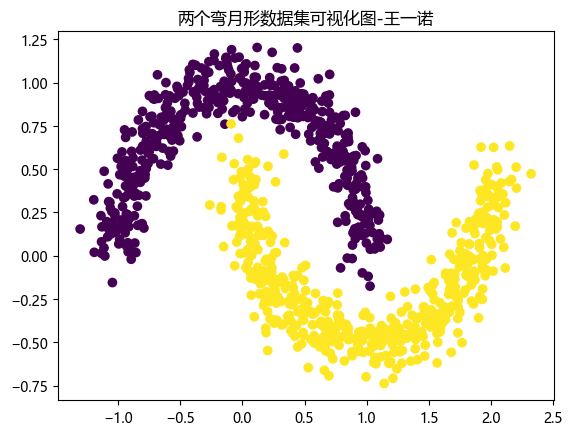

In [35]:
from kan import KAN
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
import torch
import numpy as np
plt.rcParams['font.sans-serif']=['Microsoft YaHei']

dataset = {}
train_input, train_label = make_moons(n_samples=1000, shuffle=True, noise=0.1, random_state=None)
test_input, test_label = make_moons(n_samples=1000, shuffle=True, noise=0.1, random_state=None)

dataset['train_input'] = torch.from_numpy(train_input)
dataset['test_input'] = torch.from_numpy(test_input)
dataset['train_label'] = torch.from_numpy(train_label)
dataset['test_label'] = torch.from_numpy(test_label)

X = dataset['train_input']
y = dataset['train_label']
plt.scatter(X[:,0], X[:,1], c=y[:])
plt.title("两个弯月形数据集可视化图-王一诺")

## 训练KAN。

In [36]:
model = KAN(width=[2,2], grid=3, k=3)

def train_acc():
    return torch.mean((torch.argmax(model(dataset['train_input']), dim=1) == dataset['train_label']).float())

def test_acc():
    return torch.mean((torch.argmax(model(dataset['test_input']), dim=1) == dataset['test_label']).float())

results = model.train(dataset, opt="LBFGS", steps=20, metrics=(train_acc, test_acc), loss_fn=torch.nn.CrossEntropyLoss());

train loss: 0.00e+00 | test loss: 2.84e-01 | reg: 8.25e+02 : 100%|██| 20/20 [00:01<00:00, 10.03it/s]


## 利用KAN进行自动符号回归。

In [37]:
lib = ['x','x^2','x^3','x^4','exp','log','sqrt','tanh','sin','abs']
model.auto_symbolic(lib=lib)

fixing (0,0,0) with x^3, r2=0.7720137343383552
fixing (0,0,1) with x^3, r2=0.8308033841560055
fixing (0,1,0) with x^3, r2=0.9535186508125512
fixing (0,1,1) with x^3, r2=0.9547259219420737


观察生成的公式。

In [38]:
formula1, formula2 = model.symbolic_formula()[0]
formula1

-2149.18*(0.24 - x_2)**3 + 338.46*(0.6 - x_1)**3 - 103.26

以及另一个公式。

In [39]:
formula2

2070.53*(0.24 - x_2)**3 - 400.68*(0.6 - x_1)**3 + 144.55

这两个公式到底有多准确？下面我们将用代码验证。

In [40]:
def acc(formula1, formula2, X, y):
    batch = X.shape[0]
    correct = 0
    for i in range(batch):
        logit1 = np.array(formula1.subs('x_1', X[i,0]).subs('x_2', X[i,1])).astype(np.float64)
        logit2 = np.array(formula2.subs('x_1', X[i,0]).subs('x_2', X[i,1])).astype(np.float64)
        correct += (logit2 > logit1) == y[i]
    return correct/batch

print('train acc of the formula:', acc(formula1, formula2, dataset['train_input'], dataset['train_label']))
print('test acc of the formula:', acc(formula1, formula2, dataset['test_input'], dataset['test_label']))

train acc of the formula: tensor(0.8820)
test acc of the formula: tensor(0.8810)


## 示例七：Continual Learning（持续学习）
    在此声明：我们的目标是利用样本生成一维函数。一维函数有五个高斯峰。我们使用五个学习阶段代替一股脑将所有样本都呈现给神经网络。在每个学习阶段中只有峰值附近的样本被呈现给KAN。我们发现，由于样条函数的特性，KANs可以进行持续学习。

Text(0.5, 1.0, '有5个高斯峰的高斯曲线图-王一诺')

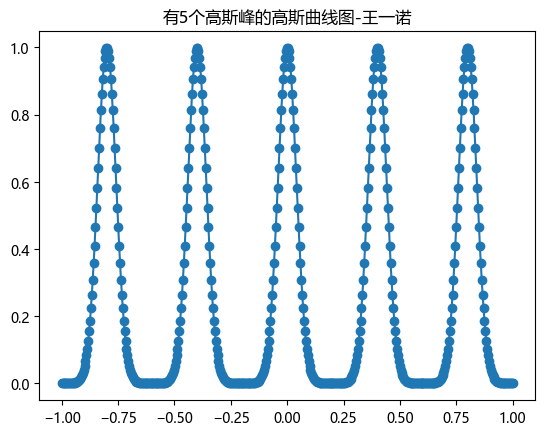

In [41]:
from kan import *
import numpy as np
import torch
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['Microsoft YaHei']

datasets = []

n_peak = 5
n_num_per_peak = 100
n_sample = n_peak * n_num_per_peak

x_grid = torch.linspace(-1,1,steps=n_sample)

x_centers = 2/n_peak * (np.arange(n_peak) - n_peak/2+0.5)

x_sample = torch.stack([torch.linspace(-1/n_peak,1/n_peak,steps=n_num_per_peak)+center for center in x_centers]).reshape(-1,)

y = 0.
for center in x_centers:
    y += torch.exp(-(x_grid-center)**2*300)

y_sample = 0.
for center in x_centers:
    y_sample += torch.exp(-(x_sample-center)**2*300)

plt.plot(x_grid.detach().numpy(), y.detach().numpy())
plt.scatter(x_sample.detach().numpy(), y_sample.detach().numpy())
plt.title("有5个高斯峰的高斯曲线图-王一诺")

## 借助KAN依次预测不同的峰。

Text(0.5, 1.0, '5个高斯峰的分布预测图-王一诺')

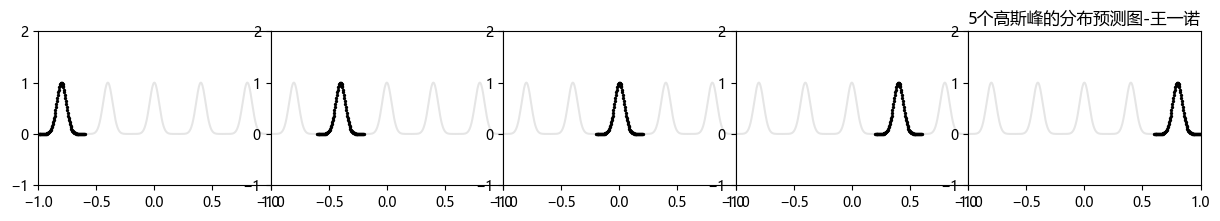

In [42]:
plt.subplots(1, 5, figsize=(15, 2))
plt.subplots_adjust(wspace=0, hspace=0)

for i in range(1,6):
    plt.subplot(1,5,i)
    group_id = i - 1
    plt.plot(x_grid.detach().numpy(), y.detach().numpy(), color='black', alpha=0.1)
    plt.scatter(x_sample[group_id*n_num_per_peak:(group_id+1)*n_num_per_peak].detach().numpy(), y_sample[group_id*n_num_per_peak:(group_id+1)*n_num_per_peak].detach().numpy(), color="black", s=2)
    plt.xlim(-1,1)
    plt.ylim(-1,2)

plt.title("5个高斯峰的分布预测图-王一诺")

## 训练KAN。

In [43]:
ys = []

# setting bias_trainable=False, sp_trainable=False, sb_trainable=False is important.
# otherwise KAN will have random scaling and shift for samples in previous stages

model = KAN(width=[1,1], grid=200, k=3, noise_scale=0.1, bias_trainable=False, sp_trainable=False, sb_trainable=False)

for group_id in range(n_peak):
    dataset = {}
    dataset['train_input'] = x_sample[group_id*n_num_per_peak:(group_id+1)*n_num_per_peak][:,None]
    dataset['train_label'] = y_sample[group_id*n_num_per_peak:(group_id+1)*n_num_per_peak][:,None]
    dataset['test_input'] = x_sample[group_id*n_num_per_peak:(group_id+1)*n_num_per_peak][:,None]
    dataset['test_label'] = y_sample[group_id*n_num_per_peak:(group_id+1)*n_num_per_peak][:,None]
    model.train(dataset, opt = 'LBFGS', steps=100, update_grid=False);
    y_pred = model(x_grid[:,None])
    ys.append(y_pred.detach().numpy()[:,0])

train loss: 3.99e-06 | test loss: 3.99e-06 | reg: 1.26e-01 : 100%|█| 100/100 [00:02<00:00, 49.93it/s
train loss: 4.00e-06 | test loss: 4.00e-06 | reg: 1.26e-01 : 100%|█| 100/100 [00:02<00:00, 41.15it/s
train loss: 4.02e-06 | test loss: 4.02e-06 | reg: 1.26e-01 : 100%|█| 100/100 [00:01<00:00, 50.13it/s
train loss: 3.99e-06 | test loss: 3.99e-06 | reg: 1.26e-01 : 100%|█| 100/100 [00:01<00:00, 50.41it/s
train loss: 3.99e-06 | test loss: 3.99e-06 | reg: 1.26e-01 : 100%|█| 100/100 [00:01<00:00, 55.64it/s


## 在每个阶段后使用KAN进行预测。

Text(0.5, 1.0, '在每个阶段后的分布预测图-王一诺')

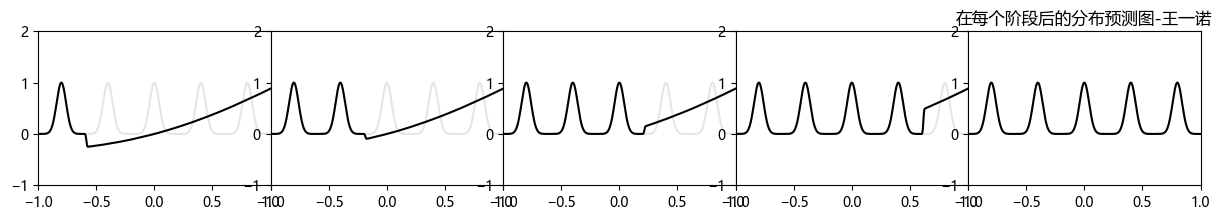

In [44]:
plt.subplots(1, 5, figsize=(15, 2))
plt.subplots_adjust(wspace=0, hspace=0)

for i in range(1,6):
    plt.subplot(1,5,i)
    group_id = i - 1
    plt.plot(x_grid.detach().numpy(), y.detach().numpy(), color='black', alpha=0.1)
    plt.plot(x_grid.detach().numpy(), ys[i-1], color='black')
    plt.xlim(-1,1)
    plt.ylim(-1,2)

plt.title("在每个阶段后的分布预测图-王一诺")

# 示例八: KANs' Scaling Laws（KAN的缩放定律）
    在这个例子中，我展示了 KAN 的缩放定律（wrt 模型参数和数据尺寸）

In [ ]:
from kan import *

import matplotlib.pyplot as plt

 # 在绘图之前设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置中文字体为黑体
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
plt.rcParams['font.sans-serif']=['Microsoft YaHei']

# 初始化KAN模型，宽度为[2,1,1], 网格大小为2, k值为3
model = KAN(width=[2,1,1], grid=3, k=3)

# 定义数据大小和网格大小数组
data_sizes = np.array([100,300,1000,3000])
grids = np.array([5,10,20,50,100])

# 初始化训练损失和测试损失矩阵
train_losses = np.zeros((data_sizes.shape[0], grids.shape[0]))
test_losses = np.zeros((data_sizes.shape[0], grids.shape[0]))
steps = 50
k = 3

# 遍历不同的数据大小和网格大小
for j in range(data_sizes.shape[0]):
    data_size = data_sizes[j]
    print(f'data_size={data_size}')
    # 创建数据集
    f = lambda x: torch.exp(torch.sin(torch.pi*x[:,[0]]) + x[:,[1]]**2)
    dataset = create_dataset(f, n_var=2, train_num=data_size)

    # 遍历不同的网格大小
    for i in range(grids.shape[0]):
        print(f'grid_size={grids[i]}')
        if i == 0:
            model = KAN(width=[2,1,1], grid=grids[i], k=k)
        if i != 0:
            model = KAN(width=[2,1,1], grid=grids[i], k=k).initialize_from_another_model(model, dataset['train_input'])
        # 训练模型
        results = model.train (dataset, opt="LBFGS", steps=steps, stop_grid_update_step = 30)
        
        # 记录训练损失和测试损失
        train_losses[j][i] = results['train_loss'][-1]
        test_losses[j][i] = results['test_loss'][-1]


## 修复数据大小，研究模型（网格）大小缩放；粗略显示缩放； $N^{-4}$ scaling.

In [ ]:
# 绘制每个数据大小的训练损失曲线，并在对数尺度上绘制
for i in range(data_sizes.shape[0]):
    plt.plot(grids, train_losses[i,:], marker="o")

# 设置X轴和Y轴为对数尺度
plt.xscale('log')
plt.yscale('log')
plt.plot(np.array([5,100]), 0.1*np.array([3,100])**(-4.), ls="--", color="black")

# 添加图例
plt.legend([f'data={data_sizes[i]}' for i in range(data_sizes.shape[0])]+[r'$N^{-4}$'])

# 设置坐标轴标签
plt.ylabel('train RMSE')
plt.xlabel('grid size')

# 设置图表标题
plt.title('KAN的缩放定律-黄颖')

In [ ]:
for i in range(data_sizes.shape[0]):
    plt.plot(grids, test_losses[i,:], marker="o")
plt.xscale('log')
plt.yscale('log')
plt.plot(np.array([5,100]), 0.1*np.array([3,100])**(-4.), ls="--", color="black")
plt.legend([f'data={data_sizes[i]}' for i in range(data_sizes.shape[0])]+[r'$N^{-4}$'])
plt.ylabel('test RMSE')
plt.xlabel('grid size')
plt.title('KAN的缩放定律-黄颖')

在研究中，我们观察到增加数据量对模型性能有显著的提升作用，尤其是对于较大网格尺寸的模型而言，这种提升更为明显；根据根据现有的研究和证据，模型和数据的规模对大语言模型性能有着重要影响。这意味着在资源有限的情况下，可以通过选择合适的数据量和模型规模来获得计算最优的模型。此外，随着模型参数量、数据集大小和用于训练的浮点数计算量的增加，模型的性能会提高，并且为了获得最佳性能，所有这些因素必须同时放。

然而，数据量对于模型性能的影响并不总是简单的线性关系。在某些情况下，数据量的增加可能不会带来预；能表现。这种方法被称为“伸缩法则”，即独立增加训练数据量、模型参数规模或者延长模型训练时间，预训练模型的效会越 好。

总之，增加数据量对模型性能有显著的提升作用，尤其是对于较大网格尺寸的模型而提，这种；升更为明显。我们情况下，人们希望同时增加数据大小和模型大小，以确保它们的复杂性始终匹配，从佳获得最；性能表现。

In [ ]:
for i in range(grids.shape[0]):
    plt.plot(data_sizes, train_losses[:,i], marker="o")
plt.xscale('log')
plt.yscale('log')
plt.plot(np.array([100,3000]), 1e8*np.array([100,3000])**(-4.), ls="--", color="black")
plt.legend([f'grid={grids[i]}' for i in range(grids.shape[0])]+[r'$N^{-4}$'])
plt.ylabel('train RMSE')
plt.xlabel('data size')
plt.title('KAN的缩放定律-黄颖')

In [ ]:
for i in range(grids.shape[0]):
    plt.plot(data_sizes, test_losses[:,i], marker="o")
plt.xscale('log')
plt.yscale('log')
plt.plot(np.array([100,3000]), 1e5*np.array([100,3000])**(-4.), ls="--", color="black")
plt.legend([f'grid={grids[i]}' for i in range(grids.shape[0])]+[r'$N^{-4}$'])
plt.ylabel('test RMSE')
plt.xlabel('data size')
plt.title('KAN的缩放定律-黄颖')

# 示例十一：Encouraging linearity（鼓励线性）

在我们不知道应该设置多少层神经网络时，有两种策略可以尝试。第一种策略是从小模型开始，逐步扩展模型的宽度和深度，直到找到一个表现良好的最小模型。另一种策略是从一个足够大的模型开始，然后逐步剪枝它。此处我采用第二种策略的情况；在这种情况下，我们不仅关注模型的稀疏性和宽度，还希望激活函数保持线性（即沿深度的“短路”）；

相关的技巧包括：
(1) 将基函数base_fun设置为线性；
(2) 惩罚样条系数；当样条系数为零时，激活函数是线性的；

### Case 1: 1D function （一维函数）
$f(x)={\rm sin}(\pi x)$. 虽然我们知道 [1,1] KAN 就足够了，但我们 假设我们不知道这一点，而是使用 [1,1,1,1] KAN 代替.

## 没有技巧的方式

In [ ]:
from kan import *
import matplotlib.pyplot as plt

 # 在绘图之前设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置中文字体为黑体
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

# create dataset f(x,y) = sin(pi*x). This task can be achieved by a [1,1] KAN
f = lambda x: torch.sin(torch.pi*x[:,[0]])
dataset = create_dataset(f, n_var=1)

model = KAN(width=[1,1,1,1], grid=5, k=3, seed=0)

model.train(dataset, opt="LBFGS", steps=20);

In [ ]:
model(dataset['train_input'])
model.plot(beta=10,title='鼓励线性-黄颖')

## 有技巧的方式

In [ ]:
from kan import *

# create dataset f(x,y) = sin(pi*x). This task can be achieved by a [1,1] KAN
f = lambda x: torch.sin(torch.pi*x[:,[0]])
dataset = create_dataset(f, n_var=1)

# set base_fun to be linear
model = KAN(width=[1,1,1,1], grid=5, k=3, seed=0, base_fun=lambda x: x)

# penality spline coefficients
model.train(dataset, opt="LBFGS", steps=20, lamb=1e-4, lamb_coef=10.0);
model(dataset['train_input'])
model.plot(beta=10,title='鼓励线性-黄颖')

### Case 2: 2D function （二维函数）

$f(x,y)={\rm exp}({\rm sin}(\pi x)+y^2)$.  我们知道一个 [2,1,1] KAN 代表它； 我们假设我们不清楚， 并且使用 [2,3,3,3,1] KAN 代替

## 没有技巧的方式

In [ ]:
# create dataset f(x,y) = exp(sin(pi*x)+y^2)
f = lambda x: torch.exp(torch.sin(torch.pi*x[:,[0]]) + x[:,[1]]**2)
dataset = create_dataset(f, n_var=2)

model = KAN(width=[2,3,3,3,1], grid=5, k=3, seed=0)
model.train(dataset, opt="LBFGS", steps=20, lamb=0.01);

In [ ]:
model(dataset['train_input'])
model.plot(beta=10,title='鼓励线性-黄颖')

In [ ]:
model = model.prune()
model(dataset['train_input'])
model.plot(beta=10,title='鼓励线性-黄颖')

## 有技巧的方式

In [ ]:
# create dataset f(x,y) = exp(sin(pi*x)+y^2)
f = lambda x: torch.exp(torch.sin(torch.pi*x[:,[0]]) + x[:,[1]]**2)
dataset = create_dataset(f, n_var=2)

model = KAN(width=[2,3,3,3,1], grid=5, k=3, seed=0)
model.train(dataset, opt="LBFGS", steps=20, lamb=0.01, lamb_coef=1.0);

In [ ]:
model(dataset['train_input'])
model.plot(beta=10,title='鼓励线性-黄颖')

In [ ]:
model = model.prune()
model(dataset['train_input'])
model.plot(beta=10,title='鼓励线性-黄颖')

# 示例十二: Unsupervised learning（无监督学习）

在此示例中，我们将使用 KAN 进行无监督学习。下面我们构建一个合成数据集，在这个数据集中有六个变量 $x_1, x_2, x_3, x_4, x_5, x_6$。$(x_1, x_2, x_3)$ 是相关的，满足 $x_3={\rm exp}({\rm sin}(\pi x_1)+x_2^2)$；$(x_4,x_5)$ 是相关的，满足 $x_5=x_4^3$。而 $x_6$ 与其他所有变量都无关。我们需要使用 KAN 来发现这些相关的变量组。

这个想法是将问题视为一个分类问题。满足这些相互依赖关系的数据集被视为“正”样本，而通过对样本之间的特征进行随机排列而破坏关系的样本被视为“负”样本。我们希望训练KAN在输入正样本时输出 1，在输入负样本时输出 0。我们将最后一层的激活函数设置为高斯函数，这样正样本在倒数第二层将具有零激活，而负样本在倒数第二层将具有非零激活。然后，我们可以隐式地定义关系为 $g=0$，其中 $g$ 是倒数第二层的激活值。

## 创建数据集

数据集包含6个变量，它们之间的关系如下：

$(x_1, x_2, x_3)$ 相关，满足 $x_3={\rm exp}({\rm sin}(\pi x_1)+x_2^2)$；

$(x_4,x_5)$ 相关，满足 $x_5=x_4^3$；

$x_6$ 与其他变量无关。

数据集的每个样本分为"正"样本和"负"样本。正样本保留了这些关系，负样本通过随机排列特征值来破坏这些关系。

In [ ]:
from kan import KAN
import torch
import copy
import matplotlib.pyplot as plt

# 创建数据集

def create_dataset(train_num=500, test_num=500):
    
    def generate_contrastive(x):
        # 正样本
        batch = x.shape[0]
        x[:,2] = torch.exp(torch.sin(torch.pi*x[:,0])+x[:,1]**2)
        x[:,3] = x[:,4]**3

        # 负样本
        def corrupt(tensor):
            y = copy.deepcopy(tensor)
            for i in range(y.shape[1]):
                y[:,i] = y[:,i][torch.randperm(y.shape[0])]
            return y

        x_cor = corrupt(x)
        x = torch.cat([x, x_cor], dim=0)
        y = torch.cat([torch.ones(batch,), torch.zeros(batch,)], dim=0)[:,None]
        return x, y
        
    x = torch.rand(train_num, 6) * 2 - 1
    x_train, y_train = generate_contrastive(x)
    
    x = torch.rand(test_num, 6) * 2 - 1
    x_test, y_test = generate_contrastive(x)
    
    dataset = {}
    dataset['train_input'] = x_train
    dataset['test_input'] = x_test
    dataset['train_label'] = y_train
    dataset['test_label'] = y_test
    return dataset

dataset = create_dataset()

# 在绘图之前设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']  
plt.rcParams['axes.unicode_minus'] = False  
seed = 1

## 初始化模型

使用KAN类来初始化一个模型实例，其中width=[6,1,1]参数表示网络的层次结构，表示输入层有6个节点，输出层有1个节点，中间有1层隐藏层，每层节点数量为1，grid=3指定了网格数量，k=3是关键点的数量，并设置了随机种子。

In [ ]:
model = KAN(width=[6,1,1], grid=3, k=3, seed=seed)

## 训练和可视化
利用构建的合成数据集对模型进行训练，并通过可视化来观察模型学习到的变量间的依赖关系。在训练过程中使用了LBFGS优化器，这是一种在机器学习中常用的优化算法，特别适用于小数据集。
### 核心
1.通过将问题转换为分类任务（正样本 vs 负样本），利用无监督学习的框架来探索和学习数据中的变量依赖关系。

2.使用高斯激活函数来标记正样本和负样本在模型中的处理差异，进而发现变量组间的相关性。

In [ ]:
model(dataset['train_input'])
model.plot(beta=10, title='KAN模型修改前训练集输入数据的可视化-毛奕婷')

In [ ]:
# 将 (1,0,0) 的激活函数设置为高斯函数
model.fix_symbolic(1,0,0,'gaussian',fit_params_bool=False)

In [ ]:
model(dataset['train_input'])
model.plot(beta=10, title='激活函数更改为高斯函数的可视化-毛奕婷')

In [ ]:
model.train(dataset, opt="LBFGS", steps=50, lamb=0.002, lamb_entropy=10.0);

In [ ]:
model.plot(in_vars=[r'$x_{}$'.format(i) for i in range(1,7)], title='训练模型50步迭代后的各输入变量的可视化-毛奕婷')

This gives the dependence among $(x_1,x_2,x_3)$. Another random seed can give dependence among $(x_4,x_5)$.

In [ ]:
seed = 42
model = KAN(width=[6,1,1], grid=3, k=3, seed=seed, noise_scale_base=1.0)
dataset = create_dataset()

In [ ]:
model(dataset['train_input'])
model.plot(beta=10,title='更改随机种子后重建数据集的初始可视化-毛奕婷')

In [ ]:
# 将 (1,0,0) 的激活函数设置为高斯函数
#model.fix_symbolic(1,0,0,lambda x: torch.exp(-x**2/10),fit_params_bool=False)
model.fix_symbolic(1,0,0,'gaussian',fit_params_bool=False)

In [ ]:
model(dataset['train_input'])
model.plot(beta=10, title='激活函数更改为高斯函数的可视化-毛奕婷')

In [ ]:
model.train(dataset, opt="LBFGS", steps=100, lamb=0.001, lamb_entropy=10.0);

In [ ]:
model.plot(in_vars=[r'$x_{}$'.format(i) for i in range(1,7)], title='训练模型100步迭代后的可视化-毛奕婷')